# Introduction: 

This research project focuses on exploratory data analysis of a dataset containing information about various products of the sport retail store. The target audience is technical, with a focus on methodology. The data *preprocessing* phase involved cleaning missing values and checking for duplicates, performed with **Excel** previously and **SQL** here (the SQL preprocessing will be shown below). 

The analysis was conducted using 90% **SQL** (SQLite). To deal with some SQLite limitations, a bit of **Pandas** has been used.  
Finally, data visualization was performed using **Seaborn**.

The research explored relationships between listing prices, discounts, and sale prices, identified top revenue-generating products, and examined price categories and brands that generated the most revenue. Additionally, correlations between the number of reviews, length of descriptions, and revenue were analyzed. The research also confirmed the product category and analyzed revenue trends by month and brand. Overall, this research aims to provide insights into pricing, customer behavior, and revenue generation based on the analyzed dataset.


### Prepare libraries and connect database.
All the data will be imported from a SQLite database. So we need to connect it before start.  
SQL is loaded and the database connected to Jupyter Lab using Ipython-SQL magic commands. It needs to be installed previously using pip/conda.


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

In [2]:
%load_ext sql


In [3]:
%sql sqlite:///C:/Users/angel/retailDB.sqlite

### Exploring the database

To begin with, our first task is to determine the composition of our database. In order to accomplish this, we will execute queries to retrieve the table names and descriptions of their columns.

In [4]:
%%sql 
SELECT 
    tbl_name, 
    sql     
FROM sqlite_master 
WHERE type = 'table'

 * sqlite:///C:/Users/angel/retailDB.sqlite
Done.


tbl_name,sql
finance,"CREATE TABLE finance ( product_id VARCHAR(50), listing_price REAL, sale_price REAL, discount REAL, revenue REAL, modified_listing_price REAL, modified_sale_price REAL, modified_discount REAL, modified_revenue REAL)"
info,"CREATE TABLE info ( product_name VARCHAR(64), product_id VARCHAR(50), description VARCHAR(512) , modified_product_name VARCHAR, modified_description VARCHAR)"
brands,"CREATE TABLE brands ( product_id VARCHAR(50), brand VARCHAR(50) , modified_brand VARCHAR)"
reviews,"CREATE TABLE reviews ( product_id VARCHAR(50), rating VARCHAR(50), reviews VARCHAR(50), ""Hour"" REAL, ""minute"" REAL, real_rating REAL, real_reviews REAL, ""Unnamed: 7"" VARCHAR(50) )"
traffic,"CREATE TABLE traffic ( product_id VARCHAR(50), last_visited TEXT(50) , modified_last_visited TEXT)"


Our database consists of five tables, each containing a few columns. Notably, all tables include a common column, *product_id*.

The finance table holds essential information regarding **revenues and prices**. Furthermore, the column text is used to store timestamp values in SQLite.

In our exploration, we will delve into identifying and handling missing values as well as detecting and managing duplicate values within the database.

In [5]:
%%sql
-- Search non-missing values.

SELECT
    COUNT(*) AS total_rows,
    COUNT(description) AS count_description,
    COUNT(sale_price) AS count_listing_price,
    COUNT(last_visited) AS count_last_visited
FROM info AS i
    INNER JOIN finance AS f
    ON i.product_id = f.product_id
    INNER JOIN traffic AS t
    ON t.product_id = i.product_id

 * sqlite:///C:/Users/angel/retailDB.sqlite
Done.


total_rows,count_description,count_listing_price,count_last_visited
3179,3179,3179,3179


#### Database Exploration: Checking for Missing Values

During our examination of the database, it appears that missing values are not prevalent.  
They are infrequent across the tables. In order to validate this observation, let's proceed with a closer inspection of the tables.

In [6]:
%%sql

--SELECT * FROM traffic LIMIT 20;
--SELECT * FROM info LIMIT 10;
--SELECT * FROM brands LIMIT 10;
--SELECT * FROM reviews LIMIT 10;
SELECT * FROM finance LIMIT 10;

 * sqlite:///C:/Users/angel/retailDB.sqlite
Done.


product_id,listing_price,sale_price,discount,revenue,modified_listing_price,modified_sale_price,modified_discount,modified_revenue
AH2430,None,None,None,None,None,None,None,None
G27341,76.0,38.0,0.5,1641.0,76.0,38.0,0.5,1641.0
CM0081,10.0,6.0,0.4,399.0,10.0,6.0,0.4,399.0
B44832,70.0,35.0,0.5,2204.0,70.0,35.0,0.5,2204.0
D98205,80.0,40.0,0.5,5183.0,80.0,40.0,0.5,5183.0
B75586,48.0,19.0,0.6,1555.0,48.0,19.0,0.6,1555.0
CG4051,48.0,24.0,0.5,86.0,48.0,24.0,0.5,86.0
CM0080,10.0,6.0,0.4,75.0,10.0,6.0,0.4,75.0
B75990,56.0,28.0,0.5,806.0,56.0,28.0,0.5,806.0
EE5761,66.0,40.0,0.4,2779.0,66.0,40.0,0.4,2779.0


### Data cleaning
Upon further examination, it appears that the value "None" is used to represent missing values across all tables in the database. However, the tables themselves indicate these values as "Not Null," which suggests that they are valid entries.

To address this issue, we have two possible approaches:

    1.Converting values to NULL: We can update the tables by replacing the "None" values with NULL using the UPDATE statement. Afterward, we can rerun the initial query to verify the absence of missing values.

    2.Creating new columns: Alternatively, we can create new columns for each existing column that contains "None" values. This allows us to preserve the original data while explicitly indicating the presence of missing values in the new columns.

Considering the potential for mistakes and the ease of reverting changes, we will opt for the second approach and create new columns for the columns with "None" values. Should any issues arise, we can easily drop the newly created columns without affecting the original table structure.


In [7]:
%%sql


ALTER TABLE finance 
ADD modified_listing_price REAL;
ALTER TABLE finance 
ADD modified_sale_price REAL;
ALTER TABLE finance 
ADD modified_discount REAL;
ALTER TABLE finance 
ADD modified_revenue REAL;


UPDATE finance 
SET modified_listing_price = CASE WHEN listing_price = 'None' THEN NULL ELSE listing_price END;
UPDATE finance 
SET modified_sale_price = CASE WHEN sale_price = 'None' THEN NULL ELSE sale_price END;
UPDATE finance 
SET modified_discount = CASE WHEN discount = 'None' THEN NULL ELSE discount END;
UPDATE finance 
SET modified_revenue = CASE WHEN revenue = 'None' THEN NULL ELSE revenue END;




 * sqlite:///C:/Users/angel/retailDB.sqlite
(sqlite3.OperationalError) duplicate column name: modified_listing_price
[SQL: ALTER TABLE finance 
ADD modified_listing_price REAL;]
(Background on this error at: https://sqlalche.me/e/20/e3q8)


### Checking missing values of Finance Table
Before proceeding with the handling of missing values, let's verify the columns in the Finance table. It is important to note that the columns in the Finance table have already been created.

Upon inspection, it becomes evident that the number of non-missing rows should differ from the total number of rows in the table. After analyzing the Finance table, I have identified 59 missing values across all columns. Interestingly, the count of missing values is consistent across each column in the table.

In [8]:
%%sql

SELECT 
    COUNT(*) AS All_rows, 
    COUNT(modified_revenue) Non_missing_values 
FROM finance LIMIT 10;

 * sqlite:///C:/Users/angel/retailDB.sqlite
Done.


All_rows,Non_missing_values
3179,3120


### Verifying Missing Values in All Columns (SQL Approach)
After successfully verifying the Finance table, we will now proceed to perform the same process on all columns using SQL queries exclusively.

By executing the necessary SQL queries, we will be able to systematically examine each column in the database and identify any missing values present. This approach allows us to efficiently analyze and handle missing values across multiple tables and columns.

In [9]:
%%sql
ALTER TABLE info 
ADD modified_product_name VARCHAR;
ALTER TABLE info 
ADD modified_description VARCHAR;

UPDATE info
SET modified_product_name = CASE WHEN product_name = 'None' THEN NULL ELSE product_name END;
UPDATE info 
SET modified_description = CASE WHEN description = 'None' THEN NULL ELSE description END;



 * sqlite:///C:/Users/angel/retailDB.sqlite
(sqlite3.OperationalError) duplicate column name: modified_product_name
[SQL: ALTER TABLE info 
ADD modified_product_name VARCHAR;]
(Background on this error at: https://sqlalche.me/e/20/e3q8)


In [10]:
%%sql

ALTER TABLE brands 
ADD modified_brand VARCHAR;

UPDATE brands
SET modified_brand = CASE WHEN brand = 'None' THEN NULL ELSE brand END;



 * sqlite:///C:/Users/angel/retailDB.sqlite
(sqlite3.OperationalError) duplicate column name: modified_brand
[SQL: ALTER TABLE brands 
ADD modified_brand VARCHAR;]
(Background on this error at: https://sqlalche.me/e/20/e3q8)


In [11]:
%%sql
--Add column
ALTER TABLE traffic 
ADD modified_last_visited TEXT;


UPDATE traffic
SET modified_last_visited = CASE WHEN last_visited = 'None' THEN NULL ELSE last_visited END;

 * sqlite:///C:/Users/angel/retailDB.sqlite
(sqlite3.OperationalError) duplicate column name: modified_last_visited
[SQL: --Add column
ALTER TABLE traffic 
ADD modified_last_visited TEXT;]
(Background on this error at: https://sqlalche.me/e/20/e3q8)


### Repeating Missing Values Test and Observations
We have conducted the missing values test again in the new columns and have obtained the number of missing values for each column in the database. Upon analysis, we have observed that only the last_visited column, which pertains to traffic information, contains a notable number of missing values, exceeding 5% of the total values in that column. However, the remaining columns do not exhibit a significant amount of missing values.

This observation indicates that the majority of columns in the database maintain a relatively complete dataset, with missing values primarily concentrated in the last_visited column.

In [12]:
%%sql

SELECT
    COUNT(*) AS total_rows,
    COUNT(modified_description) AS count_description,
    COUNT(modified_sale_price) AS count_listing_price,
    COUNT(modified_last_visited) AS count_last_visited,
    COUNT(modified_brand) AS count_brand,
    COUNT(real_rating) AS count_ratings
FROM info AS i
INNER JOIN finance AS f
    ON i.product_id = f.product_id
    INNER JOIN traffic AS t
    ON t.product_id = i.product_id
    INNER JOIN brands AS b
    ON i.product_id = b.product_id
    INNER JOIN reviews AS r
    ON i.product_id = r.product_id

 * sqlite:///C:/Users/angel/retailDB.sqlite
Done.


total_rows,count_description,count_listing_price,count_last_visited,count_brand,count_ratings
3179,3117,3120,2928,3120,3120


### Checking for Duplicates in the Product_id Column
To ensure data integrity, it is important to verify if the product_id column contains any duplicate values. Duplicate entries in this column would indicate a potential issue with the uniqueness of the product identifiers.

After performing a thorough examination, I can confirm that no duplicates were found in the product_id column. The uniqueness of the values in this column indicates that each product is uniquely identified within the database. This finding further solidifies the data quality and reinforces the integrity of the product_id column.

In [13]:
%%sql

SELECT 
    i.product_id,
    f.product_id,
    t.product_id,
    b.product_id,
    r.product_id,
    COUNT(*) AS duplicates
FROM info AS i
INNER JOIN finance AS f
ON i.product_id = f.product_id
INNER JOIN traffic AS t
ON t.product_id = i.product_id
INNER JOIN brands AS b
ON i.product_id = b.product_id
INNER JOIN reviews AS r
ON i.product_id = r.product_id
GROUP BY 
    i.product_id,
    f.product_id,
    t.product_id,
    b.product_id,
    r.product_id
HAVING COUNT(*) > 1
ORDER BY duplicates DESC;

 * sqlite:///C:/Users/angel/retailDB.sqlite
Done.


product_id,product_id_1,product_id_2,product_id_3,product_id_4,duplicates


### Dataset Prepared for Analysis
Based on the clean dataset without missing values or duplicate entries, we can confidently proceed with the analysis. Our focus will be on comparing prices between **two prominent brands, Nike and Adidas**, to gain insights into the company's stock.

In this dataset, we have a total of 77 unique prices, and the products belong to one of two brands: Nike or Adidas. To simplify the analysis and prevent overwhelming the table, I have decided to categorize the products into four **price levels**.

This categorization will allow us to examine the distribution of products across different price ranges, providing a clearer picture of the stock and pricing dynamics of the company.

In [14]:
%%sql
SELECT 
    b.modified_brand,
    CASE
        WHEN f.modified_listing_price < 42 THEN 'Budget'
        WHEN f.modified_listing_price >= 42 AND f.modified_listing_price < 74 THEN 'Average'
        WHEN f.modified_listing_price >= 74 AND f.modified_listing_price < 129 THEN 'Premium'
        WHEN f.modified_listing_price >= 129 THEN 'Exclusive'
        END AS price_category,
    COUNT(*) AS quantity
FROM finance AS f
INNER JOIN brands AS b
ON f.product_id = b.product_id
WHERE f.modified_listing_price IS NOT NULL 
GROUP BY price_category, b.modified_brand
ORDER BY f.modified_listing_price DESC;

 * sqlite:///C:/Users/angel/retailDB.sqlite
Done.


modified_brand,price_category,quantity
Adidas,Exclusive,307
Nike,Exclusive,82
Nike,Premium,90
Adidas,Premium,849
Adidas,Average,1060
Nike,Average,16
Adidas,Budget,359
Nike,Budget,357


### Analyzing Listing Prices and Sale Prices
Within our dataset, we have two distinct types of prices: listing prices and sale prices.

The listing price, in a retail context, represents the initial price at which a product or item is listed or displayed for sale by a retailer. On the other hand, the sale price refers to the discounted price at which the product or item is ultimately sold to customers.

To gain insights into the relationship between these two types of prices and the discounts offered, I will delve into the differences between listing prices and sale prices across all products. By analyzing this relationship, we can better understand the pricing strategies employed and the extent of the discounts applied to drive customer purchases.


In [15]:
%%sql
SELECT 
    modified_listing_price, 
    modified_discount, 
    modified_sale_price, 
    ROUND(modified_listing_price*(1-modified_discount) - modified_sale_price) AS control
FROM finance
WHERE modified_listing_price IS NOT NULL 
    AND ROUND(modified_listing_price*(1-modified_discount) - modified_sale_price)>1
limit 10;

 * sqlite:///C:/Users/angel/retailDB.sqlite
Done.


modified_listing_price,modified_discount,modified_sale_price,control
80.0,0.0,56.0,24.0
160.0,0.0,120.0,40.0
160.0,0.0,112.0,48.0
140.0,0.0,84.0,56.0
130.0,0.0,78.0,52.0
100.0,0.0,60.0,40.0
110.0,0.0,77.0,33.0
170.0,0.0,136.0,34.0
100.0,0.0,70.0,30.0
120.0,0.0,96.0,24.0


### Analyzing Listing Prices, Sale Prices, and Discounts
In general, the relationship between listing price, discount, and sale price follows the **formula: listing price * (1 - discount) = sale price**. However, upon analyzing the dataset, we have observed that numerous products with a **discount of 0%** were sold at a price below the listing price. This suggests that there may be anomalies in the data.

Specifically, for the Nike brand, it is unusual to find that the *sale price is greater than the listing price*. Upon closer examination, we discovered that *many listing prices for Nike products are recorded as zero*. This inconsistency in the data explains the presence of negative values when calculating the differences between the sale and listing prices.

Additionally, for the Nike brand, we observed that there are *no recorded discounts*, which is highly unlikely. These observations lead us to suspect that the input for Nike's discounts and listing prices may not have been accurately recorded in the dataset.

To address this issue, we can calculate the proportion between the sale price and the listing price, which avoids division by zero. By doing so, we can derive a calculated discount value that is similar for both Nike and Adidas (approximately 30%). This suggests that the actual discounts and listing prices for Nike may have been improperly inputted or omitted from the dataset.

In [16]:
%%sql
SELECT
    b.modified_brand,
    ROUND(AVG(f.modified_discount)*100,2) AS average_discount_pct
FROM finance AS f
INNER JOIN brands AS b
ON f.product_id = b.product_id
WHERE b.modified_brand IS NOT NULL
GROUP BY b.modified_brand;

 * sqlite:///C:/Users/angel/retailDB.sqlite
Done.


modified_brand,average_discount_pct
Adidas,33.45
Nike,0.0


In [17]:
%%sql
--Average price differences by brand
SELECT 
    b.modified_brand,
    ROUND(AVG(f.modified_listing_price - f.modified_sale_price),2) AS avg_difference, 
    ROUND(1 - AVG(f.modified_sale_price / f.modified_listing_price),2) AS avg_pct_difference
FROM finance AS f
INNER JOIN brands AS b
ON b.product_id = f.product_id
WHERE modified_brand IS NOT NULL
GROUP BY brand;

 * sqlite:///C:/Users/angel/retailDB.sqlite
Done.


modified_brand,avg_difference,avg_pct_difference
Adidas,24.51,0.33
Nike,-60.85,0.29


### Analyzing Revenues by Product
In this analysis, we will focus on examining the revenues generated by each product in the dataset. Specifically, we will identify the top ten products based on revenue.

Upon evaluating the top performers, we have observed that the majority of these products belong to the Adidas brand. Additionally, all of the top ten revenue-generating products are footwear items with prices exceeding USD 130. This trend persists when expanding the analysis to the top 20 and top 30 revenue-generating products.   
Finally, we have one outlier: the Air Jordan 10 retro.

In [18]:
%%sql
SELECT 
    f.product_id,
    i.product_name,
    b.modified_brand,
    f.modified_revenue,
    f.modified_listing_price
FROM finance AS f
INNER JOIN info AS i
ON f.product_id = i.product_id
INNER JOIN brands AS b
ON f.product_id = b.product_id
ORDER BY f.modified_revenue DESC
LIMIT 10;

 * sqlite:///C:/Users/angel/retailDB.sqlite
Done.


product_id,product_name,modified_brand,modified_revenue,modified_listing_price
310805-137,Air Jordan 10 Retro,Nike,64204.0,0.0
FV7826,Unisex Originals CRAIG GREEN KONTUUR II SHOES,Adidas,37150.0,240.0
FV6794,Unisex Originals CRAIG GREEN KONTUUR I SHOES,Adidas,34991.0,240.0
EG5185,Men's adidas Running Universal Works Ultraboost 19 Shoes,Adidas,33838.0,200.0
EF9623,Men's adidas Originals ZX 4000 4D Shoes,Adidas,31247.0,280.0
EF0893,Men's Running Ultraboost PB Shoes,Adidas,30454.0,180.0
EG0761,Women's Running Ultraboost 20 Shoes,Adidas,29986.0,170.0
EF2335,UNISEX adidas Originals Pharrell Williams Hu NMD Proud Shoes,Adidas,29699.0,220.0
EG1071,Women's adidas by Stella Mccartney Running UltraBoost 20 Shoes,Adidas,28834.0,180.0
EG5933,Men's Originals Salvapor 032c Shoes,Adidas,28762.0,170.0


### Analyzing Revenues by Product Categories

In order to check the revenue patterns across all products, I have further categorized the products into four distinct price categories. Based on this analysis, the following observations can be made:

These findings confirm and highlight the dominance of Adidas, particularly in the premium and average price categories. However, it is interesting to note that the "Exclusive" category for Adidas falls behind both the premium and average categories in terms of revenue.  
It could be attributed to the limited target audience of these exclusive products. The exclusivity factor may result in lower quantities available for sale, leading to a comparatively lower revenue generation despite potentially higher prices.  
Further analysis and investigation into the factors influencing the performance of this category may be necessary.
    

In [19]:
%%sql
SELECT
    b.brand,
    COUNT(*),
    SUM(f.modified_revenue) AS total_revenue,
    CASE
        WHEN f.modified_listing_price < 42 THEN 'Budget'
        WHEN f.modified_listing_price >= 42 AND f.modified_listing_price < 74 THEN 'Average'
        WHEN f.modified_listing_price >= 74 AND f.modified_listing_price < 129 THEN 'Premium'
        WHEN f.modified_listing_price >= 129 THEN 'Exclusive'
        END AS price_category
FROM finance AS f
INNER JOIN brands AS b
ON f.product_id = b.product_id
WHERE b.modified_brand IS NOT NULL
GROUP BY b.modified_brand, price_category
ORDER BY total_revenue DESC

 * sqlite:///C:/Users/angel/retailDB.sqlite
Done.


brand,COUNT(*),total_revenue,price_category
Adidas,849,4626990.0,Premium
Adidas,1060,3233674.0,Average
Adidas,307,3014323.0,Exclusive
Adidas,359,651657.0,Budget
Nike,357,595360.0,Budget
Nike,82,128474.0,Exclusive
Nike,90,71845.0,Premium
Nike,16,6623.0,Average


### Analyzing the Correlation between Revenues and Reviews
Understanding the correlation between revenues and reviews provides valuable insights into the impact of customer feedback and engagement on overall revenue generation.  
To explore the relationship between revenues and reviews, we will perform the correlation calculation using Python since the CORR() function is not available in SQLite. The following steps will be taken:

    1. Joining Corresponding Tables: We will join the relevant tables in SQL to obtain the necessary data for the analysis.

    2. Converting SQL Query to DataFrame: The SQL query results will be converted into a DataFrame, allowing for further analysis and calculations.

    3. Calculating Correlation: Using the DataFrame, we will calculate the correlation between revenues and reviews to determine the strength and direction of the relationship.
    
Based on the analysis, there is a significant relationship between revenues and reviews, with the number of reviews serving as a good explanatory variable for revenue generation. In other words, as the number of reviews increases, we anticipate a corresponding increase in revenues.

Additionally, it is important to note the presence of an outlier in the data, characterized by over 200 reviews and revenues exceeding USD 60,000. Whether this outlier is included or excluded from the analysis, the correlation between revenues and reviews remains largely unaffected.

In [20]:
sql_query = %sql SELECT * FROM finance AS f INNER JOIN reviews AS r ON f.product_id = r.product_id
finance_reviews = pd.DataFrame(sql_query)
fin_rev_no_outliers = finance_reviews[finance_reviews["real_reviews"] < 200]
corr = fin_rev_no_outliers["modified_revenue"].corr(fin_rev_no_outliers["real_reviews"])

print("Correlation coefficient between Revenue and Reviews: ", corr)


 * sqlite:///C:/Users/angel/retailDB.sqlite
Done.
Correlation coefficient between Revenue and Reviews:  0.649529871989546


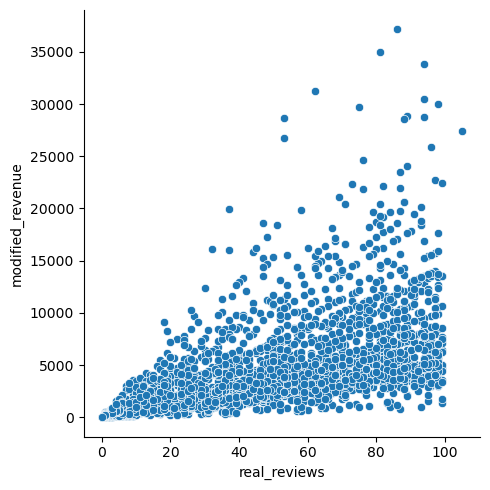

In [21]:
#We have one outlier of more than 200
sns.relplot(data = fin_rev_no_outliers, x = "real_reviews", y = "modified_revenue", kind = "scatter")

### Correlation between ratings and revenue
It appears that there is no significant correlation between the variables of ratings and revenue.


In [25]:
fin_rev_no_outliers["real_rating"] = fin_rev_no_outliers["real_rating"].str.replace(",", ".").astype(float) 
corr_rating_rev = fin_rev_no_outliers["real_rating"].corr(fin_rev_no_outliers["modified_revenue"])
print("Correlation coefficient between Revenue and Reviews: ", corr_rating_rev)



Correlation coefficient between Revenue and Reviews:  0.11343384836796092


### Analyzing the Influence of Description Length on Ratings
In this analysis, we examine the potential relationship between the length of product descriptions and their corresponding ratings. After categorizing the description length into bins of 100 characters each, we explore whether any patterns or trends emerge.

Our findings indicate that there are no clear patterns or strong correlations between the length of product descriptions and the associated ratings. The ratings appear to be similar across almost all bins, regardless of the description length.

In [26]:
%%sql
SELECT 
    (LENGTH(i.description) / 100) * 100 AS bin_start,
    ((LENGTH(i.description) / 100) + 1) * 100 AS bin_end,
    COUNT(*) AS bin_count,
    ROUND(AVG(r.real_rating), 2) AS average_rating 
FROM info AS i
INNER JOIN reviews AS r
ON i.product_id = r.product_id
WHERE description IS NOT NULL
GROUP BY (LENGTH(description) / 100)

 * sqlite:///C:/Users/angel/retailDB.sqlite
Done.


bin_start,bin_end,bin_count,average_rating
0,100,68,2.33
100,200,503,2.87
200,300,1804,2.88
300,400,652,2.88
400,500,122,2.93
500,600,15,2.73
600,700,15,3.2


### Analyzing the Influence of Description Length on Revenues

In addition to exploring the influence of description length on ratings, we also investigated its potential impact on revenues. After analyzing the data, we observed a weak positive relationship between the length of product descriptions and the generated revenues.  
Therefore, it's not a good explanatory variable of revenues.

 * sqlite:///C:/Users/angel/retailDB.sqlite
Done.


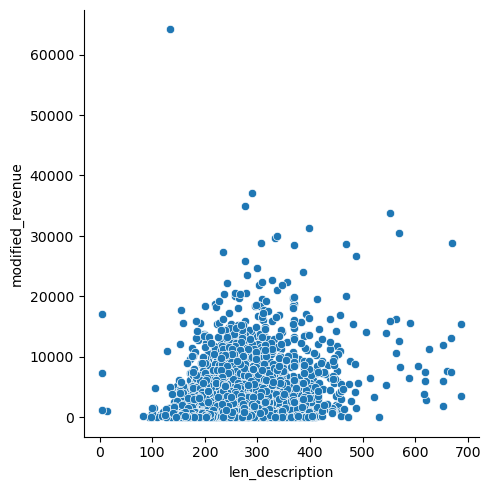

In [27]:
sql_rev_desc = %sql SELECT f.modified_revenue, i.description FROM finance AS f INNER JOIN info AS i ON f.product_id = i.product_id
df_rev_desc = pd.DataFrame(sql_rev_desc)
df_rev_desc["len_description"] = df_rev_desc["description"].str.len()
sns.relplot(data = df_rev_desc, x = "len_description", y = "modified_revenue", kind = "scatter")

In [28]:
corr_rev_desc = df_rev_desc["len_description"].corr(df_rev_desc["modified_revenue"])
print("Correlation between length of description and revenue: ", corr_rev_desc)

Correlation between length of description and revenue:  0.23036405819786768


### Analyzing Product Types in the Dataset
As we explore the dataset, it becomes apparent that the majority of products may belong to the footwear category. However, *without explicit product type segregation* in the dataset, it is important to **verify if there are other product types present**.

To investigate this, I have created a Common Table Expression (CTE) utilizing regular expressions (RegEx) to identify and retrieve all potential footwear products. By analyzing the data within this CTE, we can gain insights into the prevalence of footwear within the dataset.

Additionally, I have attempted to identify any products that are not included in the footwear CTE. This analysis aims to uncover any potential non-footwear items present in the dataset.

After conducting a thorough analysis, we can confidently conclude that all the 300 products not included in the Common Table Expression (CTE) are, indeed, footwear items. This outcome reaffirms that **100% of the products in the dataset can be classified as footwear.**

In [29]:
%%sql
WITH footwear AS
(
    SELECT i.description, f.revenue
    FROM info AS i
    INNER JOIN finance AS f 
        ON i.product_id = f.product_id
    WHERE i.modified_description LIKE '%shoe%' COLLATE NOCASE
        OR i.modified_description LIKE '%trainer%' COLLATE NOCASE
        OR i.modified_description LIKE '%foot%' COLLATE NOCASE
        OR i.modified_description LIKE '%slipper%' COLLATE NOCASE
        OR i.product_name LIKE '%shoe%' COLLATE NOCASE
        OR i.product_name LIKE '%trainer%' COLLATE NOCASE
        OR i.product_name LIKE '%foot%' COLLATE NOCASE
        OR i.product_name LIKE '%slipper%' COLLATE NOCASE
        OR i.product_name LIKE '%sandal%' COLLATE NOCASE
        OR i.product_name LIKE '%slipper%' COLLATE NOCASE
        OR i.product_name LIKE '%slide%' COLLATE NOCASE
        
        AND i.description IS NOT NULL
)
SELECT 
    product_name, 
    description
FROM info
WHERE modified_description NOT IN (select description from footwear)
    AND modified_description IS NOT NULL
LIMIT 10;

 * sqlite:///C:/Users/angel/retailDB.sqlite
Done.


product_name,description
NikeCourt Zoom Cage 3,"The NikeCourt Zoom Cage 3 offers zoned durability with a lightweight, pliable overlay that moves with you. A Zoom Air unit in the heel delivers a low-profile ride with responsive cushioning."
Nike Metcon Sport,"The Nike Metcon Sport is designed for heavy weightlifting like all Metcons, but is updated for increased agility during explosive movements and speed drills."
Jordan Mars 270,"Drawing inspiration from four classic Air Jordans, the Jordan Mars 270 is a modern-day remix that offers a heavy dose of heritage, plus an enormous Max Air unit and springy foam for non-stop comfort."
NAHA,No description
Men's adidas Essentials Eezay Flip-Flops,Be ready for warm breezes and a laid-back feel. These flip-flops feature a colorblocked design. The simple silhouette offers midsole cushioning and lightweight comfort.
Nike Flex TR 9,"Designed for low-impact workouts and circuit training, the Nike Flex TR 9 pairs a breathable mesh and synthetic upper with a supportive platform designed for flexibility and traction."
Men's adidas Comfort Flip Flops,Wear them all summer from the pool to the beach. These sandals combine rugged durability with quick-drying step-in cushioning as you spend your day in comfortable bliss. Heritage details show off your adidas inspiration.
Nike Air Force 1 '07,"The legend lives on in the Nike Air Force 1 '07, a modern take on the iconic AF1 that blends classic style with fresh colours and details."
Nike Air Force 1 Sage Low LX,"Taking both height and craft to new levels, the Nike Air Force 1 Sage Low LX features a platform midsole and pared-down upper. Rolled edges and clean lines replace traditional overlays for a bold look."
Nike Air Max Verona,"Pass on the good vibes in the Nike Air Max Verona. Elegant and versatile, its mixed-material upper features a plush collar, flashy colours and unique stitching patterns. The Nike Air cushioning adds a modern twist, comfort and style to your journey."


### Analyzing Revenue by Month and Brand
To gain insights into the revenue patterns by month and brand, we performed a study on the dataset. However, it is important to note that SQLite does not support the ROLLUP function. As a result, we had to conduct a second query to present the revenue breakdown by brand.

Insights: The brand Adidas accounts for approximately 93% of the total revenues, confirming its dominant presence in the business model. However, it is concerning that Nike's revenue contribution is not substantial. This raises a yellow flag as it suggests a potential dependence of the store on Adidas, which could pose a risk to the overall business.

Furthermore, when examining the revenue trends by month, it was observed that the **first quarter experiences a peak season** with higher revenue generation. This suggests a seasonal pattern where the initial months exhibit increased sales and revenue for the company. Limitation: the available data in the traffic table only covers the period from january-2018 to april-2020.

In [30]:
%%sql
SELECT
    b.modified_brand,
    CAST(strftime('%m', t.modified_last_visited) AS INTEGER) AS month,
    SUM(f.modified_revenue) AS revenue,
    RANK() OVER(PARTITION BY b.modified_brand ORDER BY SUM(f.modified_revenue) DESC) AS rank_months
FROM traffic AS t 
    INNER JOIN finance AS f
    ON f.product_id = t.product_id
    INNER JOIN brands AS b
    ON b.product_id = t.product_id
WHERE b.modified_brand IS NOT NULL 
    AND t.modified_last_visited IS NOT NULL 
    AND f.modified_revenue IS NOT NULL
GROUP BY b.modified_brand, month
ORDER BY revenue DESC, b.modified_brand, rank_months

 * sqlite:///C:/Users/angel/retailDB.sqlite
Done.


modified_brand,month,revenue,rank_months
Adidas,3,1160076.0,1
Adidas,2,1153612.0,2
Adidas,1,1085808.0,3
Adidas,10,908116.0,4
Adidas,8,889349.0,5
Adidas,9,879675.0,6
Adidas,4,854965.0,7
Adidas,12,796053.0,8
Adidas,7,779543.0,9
Adidas,6,727416.0,10


In [31]:
%%sql
SELECT 
    b.modified_brand,
    SUM(f.modified_revenue) AS revenue,
    ROUND(SUM(f.modified_revenue)/12328946*100) AS share_of_revenue
FROM brands AS b
    INNER JOIN finance AS f 
    ON f.product_id = b.product_id
WHERE modified_brand IS NOT NULL
GROUP BY b.modified_brand   

 * sqlite:///C:/Users/angel/retailDB.sqlite
Done.


modified_brand,revenue,share_of_revenue
Adidas,11526644.0,93.0
Nike,802302.0,7.0


In [32]:
%%sql
SELECT 
    min(modified_last_visited) AS first_visit, 
    max(modified_last_visited) AS last_visit
FROM traffic

 * sqlite:///C:/Users/angel/retailDB.sqlite
Done.


first_visit,last_visit
2018-01-01 00:00:00,2020-04-12 19:00:00


### Conclusions

- Adidas is the king with 93% of the revenue. But it may be a risk for the overall business. We need to analyze further the possible future impact. If there's no actual risk, focus on Adidas: this could involve strategic partnerships, targeted marketing campaigns, and product expansion within the Adidas brand.
- Address Inconsistencies in Pricing and Discounts: The analysis revealed potential inaccuracies in the pricing and discount data, particularly in relation to Nike products. It is recommended to thoroughly review and rectify any discrepancies to ensure the accuracy and consistency of pricing information.
- Reassess Nike Strategy: Although Nike's contribution to revenues is relatively low in comparison to Adidas, Nike has a big market-share in the world, so we need to identify potential reasons behind the lower performance and explore opportunities for improvement. This could involve refining the product range, revising pricing strategies, or implementing targeted marketing efforts to increase the brand's market presence.
- Explore Revenue Diversification: While footwear products are the main focus of the retail store, consider exploring opportunities to diversify the product offerings. This could involve expanding into related product categories or introducing complementary items that align with customer preferences and market trends. The store can provide a complement of the footwear in order to earn extra money.
- Leverage Seasonal Trends: The analysis identified a peak season in the first quarter, suggesting increased sales and revenue during that period. Capitalize on this seasonal pattern by aligning marketing efforts, promotions, and inventory management strategies to maximize sales and profitability during the high season.
- Leverage Seasonal Trends II: It is important to note that the analysis revealed lower webpage visits near Christmas and New Year. This presents an opportunity to capitalize on the holiday season when people are actively purchasing gifts. To maximize sales and engagement during this period, consider implementing targeted campaigns and marketing efforts that resonate with the holiday spirit. This could involve offering exclusive discounts, creating festive promotions, or curating gift guides to help customers find the perfect presents.